In [1]:
import transformers

In [2]:
import random

def generate_box_object_scenarios(n, num_boxes, num_objects, num_transitions):
    """
    Generate scenarios about objects in boxes with transitions.
    
    Args:
        n: Number of scenarios to generate
        num_boxes: Number of boxes in each scenario
        num_objects: Number of objects in each scenario
        num_transitions: Number of transitions (moves) in each scenario
    
    Returns:
        A list of tuples, each containing (scenario_text, answer)
    """
    # Generate box and object names
    box_names = [f"Box {chr(65 + i)}" for i in range(num_boxes)]  # Box A, Box B, etc.
    object_names = ["hat", "glove", "ball", "key", "pen", "book", "coin", "card", "ring", "watch"]
    
    if num_objects > len(object_names):
        raise ValueError(f"Set a smaller num_objects: {num_objects}")
    else:
        # Use only the required number of objects
        object_names = object_names[:num_objects]
    
    scenarios = []
    
    for _ in range(n):
        # Create a dictionary to track which objects are in which boxes
        box_contents = {box: [] for box in box_names}
        
        # Initial random placement of objects in boxes
        available_objects = object_names.copy()
        for obj in available_objects:
            box = random.choice(box_names)
            box_contents[box].append(obj)
        
        # Generate the scenario text
        scenario_text = []
        
        # Initial state description
        for box in box_names:
            for obj in box_contents[box]:
                scenario_text.append(f"{box} contains the {obj}.")
        
        # Generate transitions (moves)
        for _ in range(num_transitions):
            # Choose a random source box that has objects
            source_boxes = [box for box in box_names if box_contents[box]]
            if not source_boxes:
                break
            source_box = random.choice(source_boxes)
            
            # Choose a random object from the source box
            obj = random.choice(box_contents[source_box])
            
            # Choose a random destination box different from the source
            dest_boxes = [box for box in box_names if box != source_box]
            dest_box = random.choice(dest_boxes)
            
            # Move the object
            box_contents[source_box].remove(obj)
            box_contents[dest_box].append(obj)
            
            # Add the move to the scenario text
            scenario_text.append(f"Move the {obj} into {dest_box}.")
        
        # Select a random object for the question
        all_objects_in_boxes = [(obj, box) for box in box_names for obj in box_contents[box]]
        if all_objects_in_boxes:
            question_obj, question_box = random.choice(all_objects_in_boxes)
            
            # Create the question and answer
            question = f"{question_obj.capitalize()} is in the Box"
            answer = ' '+ question_box.split()[1]  # Extract just the letter part (A, B, etc.)
            
            # Combine all text into one scenario
            full_scenario = " ".join(scenario_text) + " " + question
            scenarios.append((full_scenario, answer))
    
    return scenarios



In [3]:
import torch
from typing import List, Tuple

def evaluate_box_object_task(
    model,
    tokenizer,
    scenarios: List[Tuple[str, str]],
    batch_size: int = 10,
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
) -> float:
    """Evaluate model accuracy on box-object task"""
    model.eval()
    
    correct_predictions = 0
    total_scenarios = len(scenarios)
    if not tokenizer.pad_token: 
        tokenizer.pad_token = tokenizer.eos_token
        
    prompts = [s[0] for s in scenarios]
    answers = [s[1] for s in scenarios]

    prompt_tokens = tokenizer(prompts, padding=True, padding_side="left", return_tensors="pt").input_ids.to("cuda")
    answer_tokens = tokenizer(answers, padding=True, padding_side="right", add_special_tokens=False, return_tensors="pt").input_ids.to("cuda")


    for i in range(0, total_scenarios, batch_size): 
        batch_prompt_tokens = prompt_tokens[i: i+batch_size]
        batch_answer_tokens = answer_tokens[i: i+batch_size].squeeze()


        last_token_logits = model(batch_prompt_tokens).logits[:, -1, :] 
        predicted_token_ids = torch.argmax(last_token_logits, dim=1)

        matches = (predicted_token_ids == batch_answer_tokens)
        correct_predictions += matches.sum().item()

    return correct_predictions / total_scenarios

 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def scan_model_accuracy(
    model,
    tokenizer,
    box_range=(2, 6),
    transition_range=(1, 6),
    num_samples=50,
    num_objects=None,  # Will use same as num_boxes if None
    batch_size=10,
    device="cuda" if torch.cuda.is_available() else "cpu"
):
    """Scan model accuracy across different configurations"""
    num_box_values = range(box_range[0], box_range[1] + 1)
    num_transition_values = range(transition_range[0], transition_range[1] + 1)
    
    # Create result matrix
    results = np.zeros((len(num_transition_values), len(num_box_values)))
    
    # Process each configuration
    for i, num_transitions in enumerate(tqdm(num_transition_values, desc="Transitions")):
        for j, num_boxes in enumerate(tqdm(num_box_values, desc="Boxes", leave=False)):
            # Set num_objects equal to num_boxes if not specified
            num_objs = num_objects if num_objects is not None else num_boxes
            
            scenarios = generate_box_object_scenarios(
                n=num_samples, 
                num_boxes=num_boxes, 
                num_objects=num_objs,
                num_transitions=num_transitions
            )

            accuracy = evaluate_box_object_task(
                model=model,
                tokenizer=tokenizer,
                scenarios=scenarios,
                batch_size=batch_size,
                device=device
            )
            
            results[i, j] = accuracy * 100
    
    plt.figure(figsize=(10, 8))
    
    cmap = plt.cm.Blues
    cmap.set_bad('white', 1.0)
    
    heatmap = plt.imshow(
        results,
        cmap=cmap,
        aspect='equal',
        vmin=0,
        vmax=100,
        origin='lower'
    )
    
    plt.xticks(np.arange(len(num_box_values)), num_box_values)
    plt.yticks(np.arange(len(num_transition_values)), num_transition_values)
    plt.xlabel('Number of Boxes')
    plt.ylabel('Number of Transitions')
    
    # cbar = plt.colorbar(heatmap)
    cbar.set_label('Accuracy (%)')
    
    for i in range(len(num_transition_values)):
        for j in range(len(num_box_values)):
            accuracy = results[i, j]
            # Only show text for non-zero values
            if accuracy > 0:
                plt.text(
                    j, i, 
                    f"{accuracy:.0f}%", 
                    ha="center", 
                    va="center", 
                    color="black" if accuracy < 70 else "white",
                    fontweight='bold'
                )
    
    plt.tight_layout()
    return plt.gcf(), results



In [5]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "openai-community/gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to("cuda")

Transitions: 100%|██████████| 10/10 [01:18<00:00,  7.87s/it]


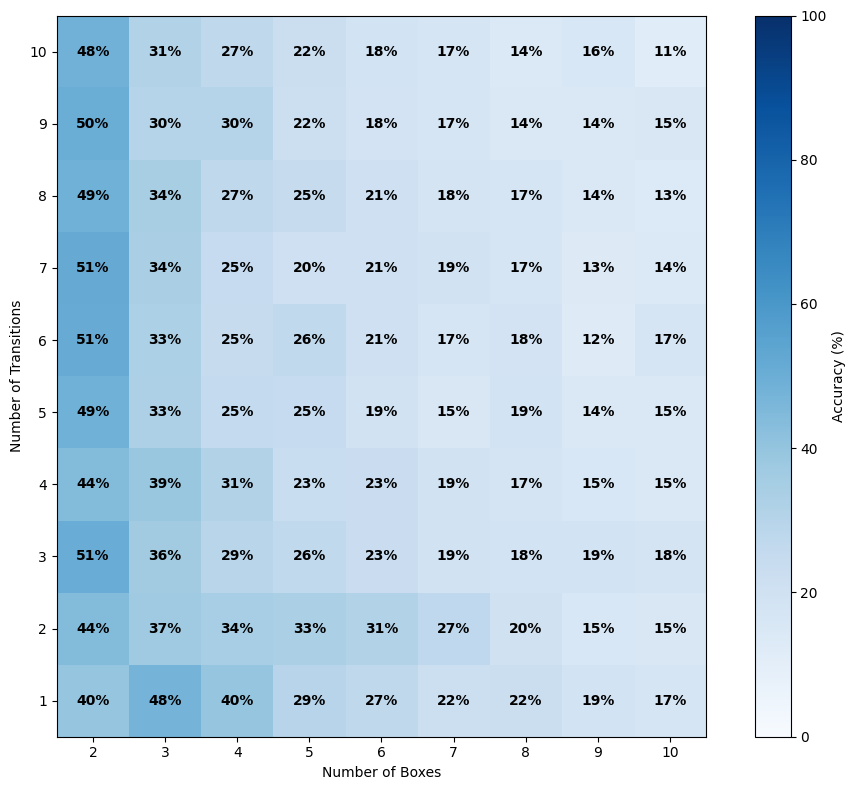

In [11]:
fig, results = scan_model_accuracy(model, tokenizer, box_range=(2, 10), transition_range=(1, 10), num_samples=500)
plt.savefig('accuracy_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()